# Customer Churn

The goal is to predict if a customer will discontinue service subscription with a telecommunications company. We employ Machine Learning binary classification algorithm to assign churn/no-churn status to a customer based on various characteristics of the customer, their subscription, and service utilization. In addition, we identify top features that contribute to customer churn and conversely, those that contribute to customer retention.

This type of predictive model is important for the business profitability, continuity, and company reputation. It can help the company to proactively prevent customers from leaving and take corrective actions to reduce further attrition.

## Library Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

In [2]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn.metrics import roc_auc_score, classification_report, matthews_corrcoef, confusion_matrix

In [3]:
# Global variables

# seed for random number generator
SEED = 1234

## Exploratory Data Analysis

In [4]:
# load the data from csv file into data frame
raw = pd.read_csv('Churn.csv')
raw.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,110,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,123,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,114,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,71,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,113,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


### Basic Information

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

In [6]:
raw.drop_duplicates()
raw.shape

(3333, 21)

There were no duplicate records in the data set. There are no null values.

In [7]:
raw.describe()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,Area_Code
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,200.980348,200.872037,10.237294,1.562856,100.435644,30.562307,100.114311,17.083540,100.107711,9.039325,4.479448,2.764581,437.182418
std,39.822106,13.688365,54.467389,50.713844,50.573847,2.791840,1.315491,20.069084,9.259435,19.922625,4.310668,19.568609,2.275873,2.461214,0.753773,42.371290
min,1.000000,0.000000,0.000000,0.000000,23.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,1.040000,0.000000,0.000000,408.000000
25%,74.000000,0.000000,143.700000,166.600000,167.000000,8.500000,1.000000,87.000000,24.430000,87.000000,14.160000,87.000000,7.520000,3.000000,2.300000,408.000000
50%,101.000000,0.000000,179.400000,201.400000,201.200000,10.300000,1.000000,101.000000,30.500000,100.000000,17.120000,100.000000,9.050000,4.000000,2.780000,415.000000
75%,127.000000,20.000000,216.400000,235.300000,235.300000,12.100000,2.000000,114.000000,36.790000,114.000000,20.000000,113.000000,10.590000,6.000000,3.270000,510.000000
max,243.000000,51.000000,350.800000,363.700000,395.000000,20.000000,9.000000,165.000000,59.640000,170.000000,30.910000,175.000000,17.770000,20.000000,5.400000,510.000000


Mean and variance of features are quite different. Need to standardize the values.

### Distributions

In [8]:
# class distribution of target variable: churn
raw.Churn.value_counts(normalize=True)

no     0.855086
yes    0.144914
Name: Churn, dtype: float64

The two classes are imbalanced. Number of customers churned (about 14%) is smaller than those who did not.

In [9]:
raw.Intl_Plan.value_counts()

no     3010
yes     323
Name: Intl_Plan, dtype: int64

In [10]:
raw.Vmail_Plan.value_counts()

no     2411
yes     922
Name: Vmail_Plan, dtype: int64

### Feature Relationships

In [11]:
ctab = pd.crosstab(raw.Intl_Plan, raw.Churn, normalize='index')
ctab

Churn,no,yes
Intl_Plan,,
no,0.885050,0.114950
yes,0.575851,0.424149


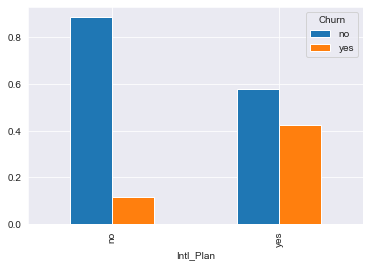

In [12]:
ctab.plot(kind='bar')
plt.show()

Among customers who don't have international plan, majority did not churn. On the other hand, majority of those who do have the international plan churned (about 57%.) Having the international plan seems to contribute to the customer churn.

In [13]:
ctab = pd.crosstab(raw.Vmail_Plan, raw.Churn, normalize='index')
ctab

Churn,no,yes
Vmail_Plan,,
no,0.832849,0.167151
yes,0.913232,0.086768


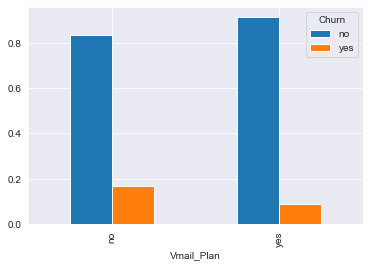

In [14]:
ctab.plot(kind='bar')
plt.show()

Having the Voicemail plan does not seem to sunstantially differentiate customers who churned and those who didn't. Voicemail plan looks like a  is a weak predictor of churn.

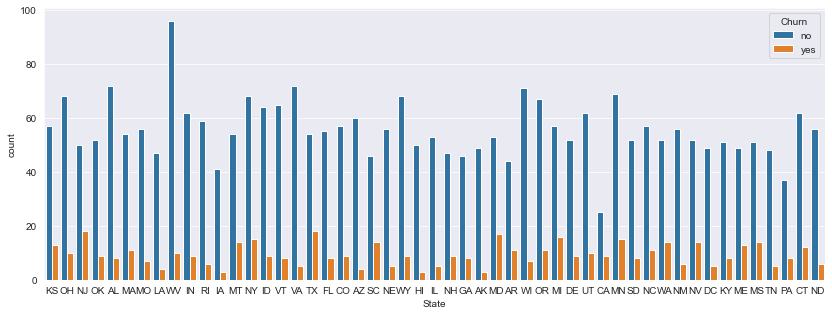

In [15]:
plt.figure(figsize=(14, 5))
sns.countplot(x='State', hue='Churn', data=raw)
plt.show()

There is some variation between states in the number of churned customers. West Virginia (WV) has the highest number of customers who have not churned. Whereas, New Jersey (NJ), Texas (TX), and Maryland (MD) have relatively higher number of churned customers.

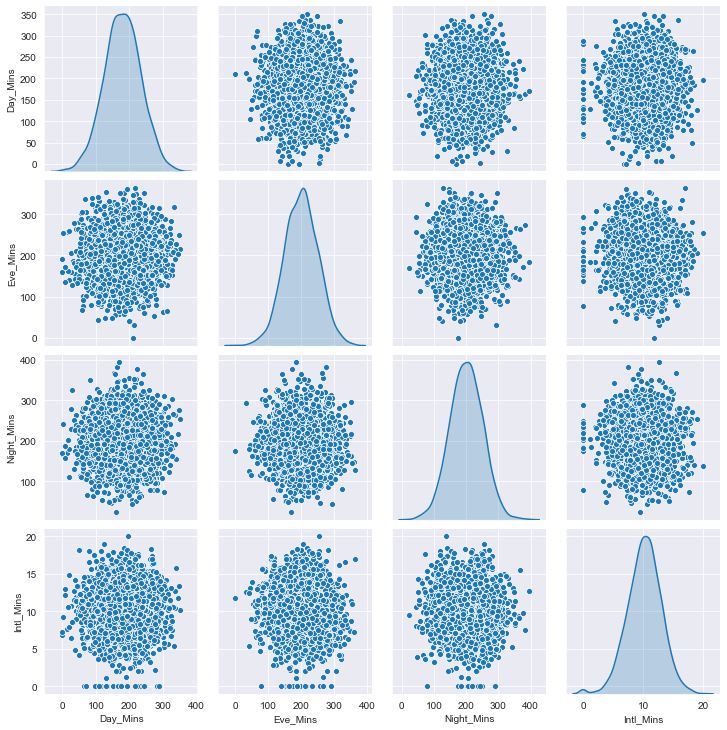

In [16]:
sns.pairplot(raw.loc[:, ['Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins']], diag_kind='kde')
plt.show()

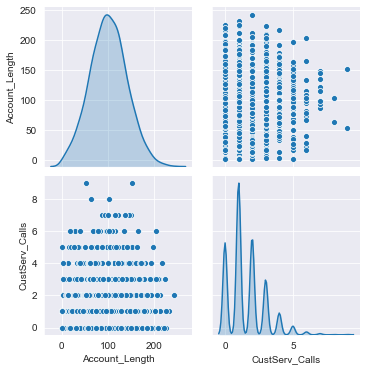

In [17]:
sns.pairplot(raw.loc[:, ['Account_Length', 'CustServ_Calls']], diag_kind='kde')
plt.show()

All the above numeric feature distributions are Gaussian (Normal curves), except CustServ_Calls, which is multi-modal. Also, these features are not correlated.

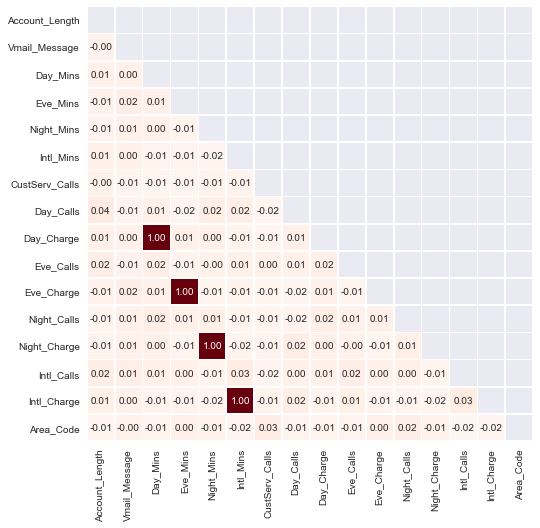

In [18]:
# calculate Pearson's correlation coefficient for pairwise numeric features
corr_matrix = raw.corr()

plt.figure(figsize=(8,8))

# creat a mask for upper triangle of correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype='bool'))

# plot  correlation matrix
sns.heatmap(corr_matrix, mask=mask, linewidths=0.7, annot=True, fmt='.2f', cmap='Reds', cbar=False)
plt.show()

Charge for day, night, evening and corresponding call minutes are perfectly correlated (Correlation coeff = 1.0). This is to be expected. One of these feature sets (charges or minutes) must be removed. 

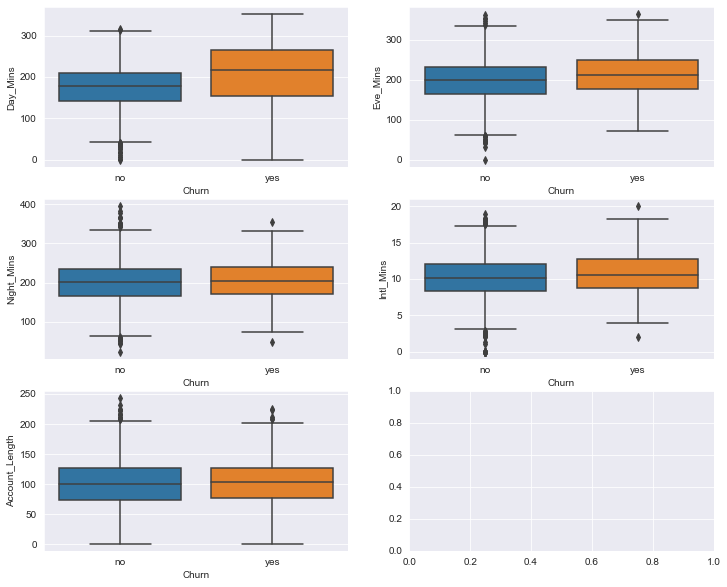

In [19]:
# distributions of numeric variables by Churn

num_df = raw.loc[:, ['Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins', 'Account_Length', 'CustServ_Calls', 'Churn']]
feature_names = ['Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins', 'Account_Length', 'CustServ_Calls']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        if k != (len(feature_names) - 1):
            sns.boxplot(x='Churn', y=feature_names[k], data=num_df, ax=axes[i][j])
            k = k + 1    
plt.show()


Only Day_Mins show variation between churned and not churned customers.

## Feature Engineering

In [20]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

In [21]:
raw.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,110,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,123,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,114,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,71,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,113,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


In [22]:
# remove useless features
df = raw.drop(['Area_Code', 'Phone'], axis=1)

In [23]:
df.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,110,45.07,99,16.78,91,11.01,3,2.70,KS
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,123,27.47,103,16.62,103,11.45,3,3.70,OH
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,114,41.38,110,10.30,104,7.32,5,3.29,NJ
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,71,50.90,88,5.26,89,8.86,7,1.78,OH
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,113,28.34,122,12.61,121,8.41,3,2.73,OK


In [24]:
# group states into regions

def assign_region(state):
    region = ''
    if state in ['CT', 'ME', 'NH', 'VT', 'RI', 'MA', 'NY', 'NJ', 'PA']:
        region = 'NE'
    elif state in ['IN', 'IL', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
        region = 'MW'
    elif state in ['DE', 'DC', 'MD', 'FL', 'GA', 'SC', 'NC', 'VA', 'WV']:
        region = 'ATL'
    elif state in ['AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX']:
        region = 'SO'
    else:
        region = 'W'
    return region

In [25]:
df['Region'] = df.State.apply(assign_region)

In [26]:
df.Region.value_counts()

W      831
MW     802
ATL    613
NE     591
SO     496
Name: Region, dtype: int64

In [27]:
df.drop('State', axis=1, inplace=True)
df.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,Region
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,110,45.07,99,16.78,91,11.01,3,2.70,MW
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,123,27.47,103,16.62,103,11.45,3,3.70,MW
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,114,41.38,110,10.30,104,7.32,5,3.29,NE
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,71,50.90,88,5.26,89,8.86,7,1.78,MW
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,113,28.34,122,12.61,121,8.41,3,2.73,SO


In [28]:
df['Total_Charge'] = df.Day_Charge + df.Eve_Charge + df.Night_Charge + df.Intl_Charge

In [29]:
df['Total_Calls'] = df.Day_Calls + df.Eve_Calls + df.Night_Calls + df.Intl_Calls

In [30]:
df.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,Region,Total_Charge,Total_Calls
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,110,45.07,99,16.78,91,11.01,3,2.70,MW,75.56,303
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,123,27.47,103,16.62,103,11.45,3,3.70,MW,59.24,332
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,114,41.38,110,10.30,104,7.32,5,3.29,NE,62.29,333
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,71,50.90,88,5.26,89,8.86,7,1.78,MW,66.80,255
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,113,28.34,122,12.61,121,8.41,3,2.73,SO,52.09,359


In [31]:
df.drop(['Day_Charge', 'Eve_Charge', 'Night_Charge', 'Intl_Charge', 
              'Day_Calls', 'Eve_Calls', 'Night_Calls', 'Intl_Calls'], axis=1, inplace=True)
df.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Region,Total_Charge,Total_Calls
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,MW,75.56,303
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,MW,59.24,332
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,NE,62.29,333
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,MW,66.80,255
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,SO,52.09,359


In [32]:
df.dtypes

Account_Length      int64
Vmail_Message       int64
Day_Mins          float64
Eve_Mins          float64
Night_Mins        float64
Intl_Mins         float64
CustServ_Calls      int64
Churn              object
Intl_Plan          object
Vmail_Plan         object
Region             object
Total_Charge      float64
Total_Calls         int64
dtype: object

In [33]:
for col in ['Intl_Plan', 'Vmail_Plan', 'Region']:
    df[col] = df[col].astype('category')
df.dtypes

Account_Length       int64
Vmail_Message        int64
Day_Mins           float64
Eve_Mins           float64
Night_Mins         float64
Intl_Mins          float64
CustServ_Calls       int64
Churn               object
Intl_Plan         category
Vmail_Plan        category
Region            category
Total_Charge       float64
Total_Calls          int64
dtype: object

In [34]:
df.Churn.value_counts()

no     2850
yes     483
Name: Churn, dtype: int64

In [35]:
# binary encode target variable: Churn=yes as 1, Churn=no as 0
df['Churn'] = df.Churn.map({'yes':1, 'no':0})

In [36]:
len(df[df.Churn > 0])

483

In [37]:
df.shape

(3333, 13)

In [38]:
df.dtypes

Account_Length       int64
Vmail_Message        int64
Day_Mins           float64
Eve_Mins           float64
Night_Mins         float64
Intl_Mins          float64
CustServ_Calls       int64
Churn                int64
Intl_Plan         category
Vmail_Plan        category
Region            category
Total_Charge       float64
Total_Calls          int64
dtype: object

In [39]:
df = pd.get_dummies(df)
df.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Total_Charge,Total_Calls,Intl_Plan_no,Intl_Plan_yes,Vmail_Plan_no,Vmail_Plan_yes,Region_ATL,Region_MW,Region_NE,Region_SO,Region_W
0,128,25,265.1,197.4,244.7,10.0,1,0,75.56,303,1,0,0,1,0,1,0,0,0
1,107,26,161.6,195.5,254.4,13.7,1,0,59.24,332,1,0,0,1,0,1,0,0,0
2,137,0,243.4,121.2,162.6,12.2,0,0,62.29,333,1,0,1,0,0,0,1,0,0
3,84,0,299.4,61.9,196.9,6.6,2,0,66.80,255,0,1,1,0,0,1,0,0,0
4,75,0,166.7,148.3,186.9,10.1,3,0,52.09,359,0,1,1,0,0,0,0,1,0


In [40]:
# drop redundant binary dummy columns
df.drop(['Intl_Plan_no', 'Vmail_Plan_no'], axis=1, inplace=True)
df.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Total_Charge,Total_Calls,Intl_Plan_yes,Vmail_Plan_yes,Region_ATL,Region_MW,Region_NE,Region_SO,Region_W
0,128,25,265.1,197.4,244.7,10.0,1,0,75.56,303,0,1,0,1,0,0,0
1,107,26,161.6,195.5,254.4,13.7,1,0,59.24,332,0,1,0,1,0,0,0
2,137,0,243.4,121.2,162.6,12.2,0,0,62.29,333,0,0,0,0,1,0,0
3,84,0,299.4,61.9,196.9,6.6,2,0,66.80,255,1,0,0,1,0,0,0
4,75,0,166.7,148.3,186.9,10.1,3,0,52.09,359,1,0,0,0,0,1,0


In [41]:
df.shape

(3333, 17)

In [42]:
df.dtypes

Account_Length      int64
Vmail_Message       int64
Day_Mins          float64
Eve_Mins          float64
Night_Mins        float64
Intl_Mins         float64
CustServ_Calls      int64
Churn               int64
Total_Charge      float64
Total_Calls         int64
Intl_Plan_yes       uint8
Vmail_Plan_yes      uint8
Region_ATL          uint8
Region_MW           uint8
Region_NE           uint8
Region_SO           uint8
Region_W            uint8
dtype: object

### Prepare Analytical Base Table

In [43]:
y = df['Churn']

In [44]:
X = df.loc[:, df.columns != 'Churn']

In [45]:
feature_names = list(X.columns)

In [46]:
binary_features = list(X.select_dtypes(include=['uint8']).columns)
print(binary_features)

['Intl_Plan_yes', 'Vmail_Plan_yes', 'Region_ATL', 'Region_MW', 'Region_NE', 'Region_SO', 'Region_W']


In [47]:
num_features = list(X.select_dtypes(include=['int64', 'float64']).columns)
print(num_features)

['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins', 'CustServ_Calls', 'Total_Charge', 'Total_Calls']


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

In [49]:
print(X_train.shape, X_test.shape)

(2666, 16) (667, 16)


In [50]:
print(y_train.shape, y_test.shape)

(2666,) (667,)


## Model Selection

In [51]:
# function to select only categorical features from data frame x

get_binary_data = FunctionTransformer(lambda x: x[binary_features], validate=False)

In [52]:
# create pipeline to select categorical features and apply one-hot-encoding to them

binary_pipe = make_pipeline(get_binary_data)

In [53]:
# function to select numeric features from data frame x

get_num_data = FunctionTransformer(lambda x: x[num_features], validate=False)

In [54]:
# create pipeline to select numeric features and scale them (with mean=0, stdev=1)

num_pipe = make_pipeline(get_num_data, StandardScaler())

In [55]:
# combine numeric and categorical features preprocessing pipelines

preprocess_data = FeatureUnion(transformer_list = [('num_features', num_pipe),
                                            ('binary_features', binary_pipe)])

In [56]:
# create pipeline dictionary for all models (with default model parameters, unless otherwise specified.)

pipelines = {'rfc': make_pipeline(preprocess_data, 
                            RandomForestClassifier(class_weight='balanced', random_state=SEED)),
            
             'gbc': make_pipeline(preprocess_data, 
                            GradientBoostingClassifier(random_state=SEED)),
             
             'svc_linear': make_pipeline(preprocess_data, 
                            SVC(kernel='linear', probability=True, random_state=SEED)),
             
             'svc_rbf': make_pipeline(preprocess_data, 
                            SVC(kernel='rbf', probability=True, random_state=SEED)),
             
             'lr': make_pipeline(preprocess_data, 
                            LogisticRegression(class_weight='balanced', random_state=SEED))
            }

#### Get baseline scores of several models on training data set

In [57]:
# ROC AUC is a better metric (than accuracy) for imbalanced classes
baseline_auc = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_train)[:, 1]
    auc = roc_auc_score(y_train, y_prob).round(3)
    baseline_auc[name] = auc

In [58]:
print(baseline_auc)

{'rfc': 1.0, 'gbc': 0.986, 'svc_linear': 0.757, 'svc_rbf': 0.93, 'lr': 0.819}


GradientBoostingClassifier and RandomForestClassifier have the 2 highest training AUC scores. We'll tune the hyperparameters of these two models and select the best one.

#### Select the best model using cross-validation

In [59]:
# create hyperparameter dictionaries
gbc_hyperparameters = {'gradientboostingclassifier__n_estimators': [100, 200, 300, 400],
                       'gradientboostingclassifier__learning_rate': [0.001, 0.01, 0.1],
                       'gradientboostingclassifier__max_depth': [3, 5, 7],
                       'gradientboostingclassifier__subsample': [0.5, 1]}

rfc_hyperparametrs = {'randomforestclassifier__n_estimators': [100, 200, 300],
                      'randomforestclassifier__min_samples_split': [2, 5, 7]}

In [60]:
# create hyperparameters dictionary for all models
hyperparameters = dict(gbc = gbc_hyperparameters, rfc = rfc_hyperparametrs)

In [61]:
pipelines = {'rfc': make_pipeline(preprocess_data, 
                            RandomForestClassifier(class_weight='balanced', random_state=SEED)),
            
             'gbc': make_pipeline(preprocess_data, 
                            GradientBoostingClassifier(random_state=SEED))
            }

In [62]:
# find the best hyperparameters using cross-validation and fit the best models to the training data set

fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, scoring='roc_auc')
    model.fit(X_train, y_train)
    
    fitted_models[name] = model
    print('{} model CV on training data set complete.'.format(name))

rfc model CV on training data set complete.
gbc model CV on training data set complete.


In [63]:
# calculate predicted probabilities and AUC score on test data set

for name, model in fitted_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob).round(3)
    
    print(name, 'Test AUC: ', auc)

rfc Test AUC:  0.94
gbc Test AUC:  0.925


RandomForestClassifer yields the best cross-validated test AUC score of 94%.

In [76]:
fitted_models['rfc'].best_params_

{'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 200}

In [73]:
y_pred = fitted_models['rfc'].predict(X_test)

In [82]:
mcc = matthews_corrcoef(y_test, y_pred)
print(mcc.round(3))

0.863


Matthews Correlation Coefficient is a balanced measure of the quality of binary classification. MCC value of 0.863 is very good, where MCC=1.0 indicates perfect classification. 

In [77]:
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

              precision    recall  f1-score   support

    No Churn       0.96      1.00      0.98       570
       Churn       1.00      0.77      0.87        97

    accuracy                           0.97       667
   macro avg       0.98      0.89      0.93       667
weighted avg       0.97      0.97      0.97       667



In [ ]:
print(confusion_matrix(y_test, y_pred))

All the observations with true 'No Churn' label were classified correctly. Out of all the 'Churn' observations, about 77% were classified correctly. F1-score of 0.87 is very good, given that the score of 1.0 indicates perfect precision and recall. Since the two classes are imbalanced, F1-score is a better measure of prerformance than accuracy. 

AUC of 0.94 means that the model will classify a randomly selected customer accorrectly with 94% probability. However, it'd be desirable to reduce the classification error for the 'Churn' class. 

#### Find out which features are important for predicting customer churn

In [78]:
importances = fitted_models['rfc'].best_estimator_.named_steps['randomforestclassifier'].feature_importances_
print(importances.round(3))

[0.049 0.031 0.13  0.065 0.053 0.062 0.16  0.253 0.05  0.104 0.018 0.005
 0.007 0.005 0.004 0.005]


In [79]:
# sort the indices of importance scores array in descending order and fetch indices of the top 10 highest values
indices = np.argsort(importances)[:-11:-1]
print(indices)

[7 6 2 9 3 5 4 8 0]


In [83]:
print("Feature ranking:\n")

feature_names = X.columns

for i in indices:
    print("%s feature %d (%f)" % (feature_names[i], i, importances[i]))

Feature ranking:

Total_Charge feature 7 (0.252999)
CustServ_Calls feature 6 (0.159613)
Day_Mins feature 2 (0.129553)
Intl_Plan_yes feature 9 (0.104145)
Eve_Mins feature 3 (0.064784)
Intl_Mins feature 5 (0.062000)
Night_Mins feature 4 (0.053156)
Total_Calls feature 8 (0.049687)
Account_Length feature 0 (0.048670)


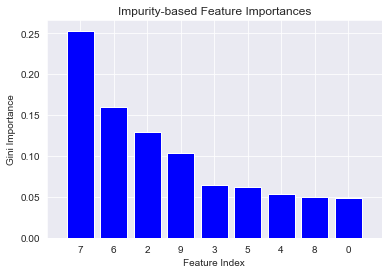

In [81]:
# Plot the impurity-based feature importances of Gradient Boosting Classifier

plt.figure()
plt.title("Impurity-based Feature Importances")

plt.bar(range(len(indices)), importances[indices],
        color="blue", align="center")

plt.xlabel("Feature Index")
plt.ylabel("Gini Importance")

plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
plt.show()

Total_Charge, CustServ_Calls, and Day_Mins are the three most important features for predicting customer churn using this classifier. (Feature importance is model-specific. It does not imply intrinsic ability of the feature as good predictor.)